# Creating a Fitness Function

## Import Modules

In [1]:
# Import Python Mobules
import os, json, time, argparse
import numpy as np
from sys import argv
import tensorflow as tf
import tensorflow.keras as keras

# Reduce warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Basic information 1
print("Modules: Imported")

Modules: Imported


## Define Command Line Arguments

In [2]:
# Command line arguments

buildEnv = False

parser = argparse.ArgumentParser()
parser.add_argument( '-runName', )
parser.add_argument( '-modelLoc', )
parser.add_argument( "-tid",      default = '587722984435351614',  type=str )
parser.add_argument( "-start",    default = 0,  type=int, )
parser.add_argument( "-stop",     default = 3,  type=int, )
parser.add_argument( "-verbose",  default = 1,  type=int, )
parser.add_argument( "-num_epochs",    default=2,       type=int )
parser.add_argument( "-learning_rate", default=0.0001,  type=float )
parser.add_argument( "-batch_size",    default=16,      type=int )
parser.add_argument( "-save_model",    default='True', type=str )
parser.add_argument( "-data_gen",      default='True',  type=str )

# Core Model types
parser.add_argument( "-model",   default = 'efficientNetB0', type=str)
parser.add_argument( "-pool",    default = 'None',           type=str )
parser.add_argument( "-weights", default = 'imagenet',       type=str )

# Final layers
parser.add_argument( "-f_depth", default = 8,  type=int )
parser.add_argument( "-f_width", default = 32, type=int )
parser.add_argument( "-f_activation", default = 'relu', type=str )
parser.add_argument( "-output_activation", default = 'sigmoid' )

print("Args: Defined")

Args: Defined


## Establish if Building Environment or Script
Notice if code can see it's in a Jupyter Notebook Environment, it can create an artificial string of command line arguments.  This is convenient for testing the code in a Jupyter Notebook directly and changing variables on the fly.  Then when the Notebook is compiled as a python script, all changes can be stored.

In [3]:

# Am I in a jupyter notebook?
try:
    get_ipython().__class__.__name__
    buildEnv = True
    print("In Build")
    
    # Build Command Line Arguments
    cmdStr = ''
    cmdStr += ' -runName target-demo'
    cmdStr += ' -start 1'
    cmdStr += ' -stop 20'
    cmdStr += ' -num_epochs 20'
    cmdStr += ' -learning_rate 0.0001'
    cmdStr += ' -pool None'
    cmdStr += ' -verbose 1'
    cmdStr += ' -save_model False'
    cmdStr += ' -f_depth 3'
    cmdStr += ' -f_width 32'
    cmdStr += ' -f_activation relu'
    cmdStr += ' -output_activation sigmoid'
    cmdStr += ' -model efficientNetB0'
    cmdStr += ' -data_gen True'
    
    # Read string as if command line
    args = parser.parse_args(cmdStr.split())


# Or am I in a python script?
except:
    
    # Read CMD arguments
    args = parser.parse_args()
    
    # Check for valid runName
    print( 'runName: ', args.runName )
    if args.runName == None:
        print("WARNING:  runName required")
        exit()

# Preprocess some cmd args
if args.save_model == 'True': args.save_model = True 
else:  args.save_model = False

if args.data_gen == 'True': args.data_gen = True 
else:  args.data_gen = False


print("Args: Read")
print( args )

In Build
Args: Read
Namespace(runName='target-demo', modelLoc=None, tid='587722984435351614', start=1, stop=20, verbose=1, num_epochs=20, learning_rate=0.0001, batch_size=16, save_model=False, data_gen=True, model='efficientNetB0', pool='None', weights='imagenet', f_depth=3, f_width=32, f_activation='relu', output_activation='sigmoid')


## Define Device Strategy for Tensor Flow

In [4]:

# Read current devices
devices = tf.config.get_visible_devices()

# If no GPU found, use CPU
if len(devices) == 1:
    strategy = tf.distribute.OneDeviceStrategy('CPU') # Use local GPU

# if buildEnv, probably on hamilton. Use GPU 2
elif buildEnv:
    print("Using 2nd GPU")
    tf.config.set_visible_devices(devices[0:1]+devices[2:3])
    #tf.config.experimental.set_memory_growth(devices[1],True)
    strategy = tf.distribute.OneDeviceStrategy('GPU:1') # Use local GPU

# Standard single GPU on backus
else:
    #tf.config.experimental.set_memory_growth(devices[1],True)
    strategy = tf.distribute.OneDeviceStrategy('GPU:1') # Use local GPU

print( 'Devices:', devices )


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Define Useful Functions

In [5]:
def sliceKey( dictIn ):
    dictOut =  dictIn
    for k in dictOut:
        if type( dictOut[k] ) == type( 'string' ):
            if 'slice' in dictOut[k]:
                #print( k, dictOut[k] )
                tmp = dictOut[k].split('(')[1].split(')')[0].split(',')
                s = int( tmp[0] )
                e = int( tmp[1] )
                dictOut[k] = slice( s, e )
                #print( dictOut[k] )
    
    return dictOut 

def correlation(y_true, y_pred):
    y = y_pred.numpy()
    corr = np.corrcoef( y_true[:,0], y[:,0] )[0,1]
    return corr

def loadData( args ):
    
    # Prepare data
    with open( 'data/data-key.json' ) as keyFile:
        key = json.load( keyFile )
    
    print("Reading Data for: %s" % args.tid )
        
    data = np.load('data/data-%s.npy' % args.tid)
    img = np.load( 'data/img-%s.npy' % args.tid )
    
    # Rescale image values based on core model being used.
    if 'efficientNet' in args.model :
        img *= 255

    if buildEnv:
        print( 'data: ', data.shape )
        print( 'img:  ', img.shape, np.amin(img), np.amax(img) )
    
    # Reserve every 5th for training
    n = data.shape[0]
    m = np.full( n, False )
    m[::5] = True
    
    # Seperate training from testing
    testData = data[m] 
    testImg  = img[m]
    
    trainData = data[~m]
    trainImg = img[~m]
    
    # Shuffle training data
    
    p = np.random.permutation( trainData.shape[0] )
    trainData = trainData[p]
    trainImg = trainImg[p]
    
    if buildEnv:
        print( "test:  ", testData.shape )
        print( "train: ", trainData.shape )
    
    # Only grab scores for prediction    
    trainScore = trainData[:,key['score']]
    testScore  =  testData[:,key['score']]
    
    # Reshape scores
    testScore  = np.reshape( testScore,  (  testScore.shape[0], 1 ) )
    trainScore = np.reshape( trainScore, ( trainScore.shape[0], 1 ) )
    
    # print scores shape
    
    if buildEnv:
        print('testScore:', testScore.shape, np.amin( testScore ), np.amax(testScore) )
        print("trainScore:", trainScore.shape )
    
    # Set standardized name
    
    return trainImg, trainScore, testImg, testScore
    
with strategy.scope():
    X, Y, Xval, Yval = loadData( args )

Reading Data for: 587722984435351614
data:  (315, 25)
img:   (315, 128, 128, 3) 0.0 255.0
test:   (63, 25)
train:  (252, 25)
testScore: (63, 1) 0.02857142857142857 0.9459459459459459
trainScore: (252, 1)


## Build Model

In [6]:

def buildModel( args, X, Y ):
    
    # Preprocess some input arguments
    if args.pool == 'None': args.pool = None
    if args.weights == 'None': args.weights = None
    
    # Build input layer
    x = keras.layers.Input(shape=X.shape[1:], name='Input_Layer')
    y = x    
    
    # What type of model
    if 'efficientNet' in args.model:
    
        if   args.model == 'efficientNetB0':  core_model = tf.keras.applications.EfficientNetB0
        elif args.model == 'efficientNetB1':  core_model = tf.keras.applications.EfficientNetB1
        elif args.model == 'efficientNetB2':  core_model = tf.keras.applications.EfficientNetB2
        elif args.model == 'efficientNetB3':  core_model = tf.keras.applications.EfficientNetB3
        elif args.model == 'efficientNetB4':  core_model = tf.keras.applications.EfficientNetB4
        elif args.model == 'efficientNetB5':  core_model = tf.keras.applications.EfficientNetB5
        elif args.model == 'efficientNetB6':  core_model = tf.keras.applications.EfficientNetB6
        elif args.model == 'efficientNetB7':  core_model = tf.keras.applications.EfficientNetB7
            
        core_model =  core_model(
                include_top=False,
                weights=args.weights,
                input_shape=y.shape[1:],
                pooling=args.pool,
            )
    
    elif args.model == 'resnet':
        # Build resnet layer without top layer
        core_model = keras.applications.ResNet50V2(
            include_top = False,
            weights = args.weights,
            input_shape = y.shape[1:], 
        )
    else:
        print("NO MODEL TYPE SELECTED")
        return None
    
    # Add core model
    y = core_model(y)
    
    # Flatten for final layers
    y = keras.layers.Flatten(name='Flatten_Layer')(y)
        
    for i in range( args.f_depth ):
        
        if args.f_activation == None:
            y = keras.layers.Dense( args.f_width, activation= keras.activations.relu, name='relu_%d'%i )(y)
            
        if args.f_activation == 'relu':
            y = keras.layers.Dense( args.f_width, activation= keras.activations.relu, name='relu_%d'%i )(y)
            
        if args.f_activation == 'tanh':
            y = keras.layers.Dense( args.f_width, activation= keras.activations.tanh, name='tanh_%d'%i )(y)
    
    # Final layer.
    if args.output_activation == None or args.output_activation == 'linear':
        y = keras.layers.Dense( Y.shape[1], name='Output_Linear' )(y)
        
    elif args.output_activation == 'softmax':
        y = keras.layers.Dense( Y.shape[1] , activation='softmax', name='Output_Softmax' )(y)
        
    elif args.output_activation == 'sigmoid':
        y = keras.layers.Dense( Y.shape[1] , activation='sigmoid', name='Output_Sigmoid' )(y)


    # Compile
    model = keras.Model( x, y )
    model.compile( 
        optimizer=keras.optimizers.Adam( learning_rate = args.learning_rate ),
        loss=keras.losses.mean_squared_error,
        )
    
    return model
# end building model
    
with strategy.scope(): 

    # If not reading previous model, make fresh model
    model = buildModel( args, X, Y )
    model.summary(expand_nested=False)

# keras.utils.plot_model(model,show_shapes=True,expand_nested=False)

    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 Flatten_Layer (Flatten)     (None, 20480)             0         
                                                                 
 relu_0 (Dense)              (None, 32)                655392    
                                                                 
 relu_1 (Dense)              (None, 32)                1056      
                                                                 
 relu_2 (Dense)              (None, 32)                1056      
                                                                 
 Output_Sigmoid (Dense)      (None, 1)                 33    

## Prepare Data Generator and Initialize Results File

In [7]:
with strategy.scope(): 
        
    # Quick prediction to test functionality
    if buildEnv: 
        print("Starting Predictions: ", model.predict( X[:4] )[:,0])
        
    if args.data_gen: 
        print("Using Data Generator:")
        data_generator = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            zoom_range=0.1,
            horizontal_flip=True,
        )
    else: 
        print("Data As Is:")
        data_generator = keras.preprocessing.image.ImageDataGenerator()

    dg_trainer = data_generator.flow( 
            X, Y, 
            batch_size = args.batch_size
        )
    
    allLoss = []
    valLoss = []
    
    print( 'Ready to Train:' )
    print( 'runName: %s' % args.runName )
    print( 'start: %d' % args.start )
    print( 'goal: %d' % args.stop )

    with open( 'results/%s.txt' % args.runName, 'a' ) as f: 

        print( 'runName: %s' % args.runName, file=f )
        print( 'start: %d' % args.start, file=f )
        print( 'goal: %d' % args.stop, file=f )

Starting Predictions:  [0.5614575  0.56850874 0.55905235 0.57135665]
Using Data Generator:
Ready to Train:
runName: target-demo
start: 1
goal: 20


## Train Model

In [14]:
with strategy.scope():
      
    # Initialize iter
    i = args.start   
    
    while i < args.stop:

        history = model.fit(
           dg_trainer,
#             X, Y,
            validation_data = ( Xval, Yval ),
            epochs     = args.num_epochs,
            verbose    = args.verbose,
        )
        
        # Save loss
        allLoss = np.append( allLoss, history.history['loss'] )
        valLoss = np.append( valLoss, history.history['val_loss'] )

        i += args.num_epochs
        timeid = int( time.time() )
        
        # Print Progress
        print( 'Progress: %d - %d' % ( i, args.stop ) )
        
        if buildEnv:           
            print( 'Progress: %d - %d' % ( i, timeid ))
            print( "Training accuracy:",*["%.8f"%(x) for x in history.history['loss']])    
            print( "Test accuracy:",*["%.8f"%(x) for x in history.history['val_loss']])

        if args.save_model: 
            model.save( 'models/%s-%s-%s.h5' % (args.runName, str(timeid), str(i)), save_format='h5' )

        with open( 'results/%s.txt' % args.runName, 'a' ) as f: 

            print( 'Progress: %d - %d' % ( i, timeid ), file=f )
            print( "Training accuracy:",*["%.8f"%(x) for x in history.history['loss']], file=f)    
            print( "Test accuracy:",*["%.8f"%(x) for x in history.history['val_loss']],file=f)


Epoch 1/20
16/16 [==============================] - 8s 421ms/step - loss: 0.0256 - val_loss: 0.0571
Epoch 2/20
16/16 [==============================] - 6s 404ms/step - loss: 0.0245 - val_loss: 0.0574
Epoch 3/20
16/16 [==============================] - 6s 402ms/step - loss: 0.0257 - val_loss: 0.0577
Epoch 4/20
16/16 [==============================] - 6s 403ms/step - loss: 0.0258 - val_loss: 0.0585
Epoch 5/20
16/16 [==============================] - 6s 404ms/step - loss: 0.0259 - val_loss: 0.0501
Epoch 6/20
16/16 [==============================] - 6s 403ms/step - loss: 0.0260 - val_loss: 0.0490
Epoch 7/20
16/16 [==============================] - 7s 405ms/step - loss: 0.0217 - val_loss: 0.0440
Epoch 8/20
16/16 [==============================] - 6s 403ms/step - loss: 0.0215 - val_loss: 0.0409
Epoch 9/20
16/16 [==============================] - 7s 406ms/step - loss: 0.0208 - val_loss: 0.0391
Epoch 10/20
16/16 [==============================] - 6s 404ms/step - loss: 0.0223 - val_loss: 0.0381

## View Ongoing Loss and Predictions

dict_keys(['loss', 'val_loss'])


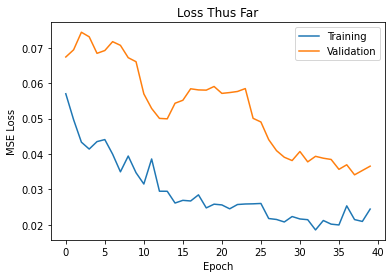

In [15]:
if buildEnv: 
    import matplotlib.pyplot as plt
    print( history.history.keys() )
    plt.plot( allLoss )
    plt.plot( valLoss )
    plt.title("Loss Thus Far")
    plt.legend(['Training','Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    #plt.ylim([0,1])
    plt.show()


In [16]:
if buildEnv: 
    
    pTestScores = model.predict( Xval )
    pTrainScores = model.predict( X )

    print( Y.shape, Yval.shape )
    print( pTestScores.shape, pTrainScores.shape )

    trainCorr = np.corrcoef(  Y[:,0], pTrainScores[:,0] )[0,1]
    testCorr = np.corrcoef(  Yval[:,0], pTestScores[:,0] )[0,1]
    print( trainCorr, testCorr )

(252, 1) (63, 1)
(63, 1) (252, 1)
0.7988371870058325 0.6797934429299275


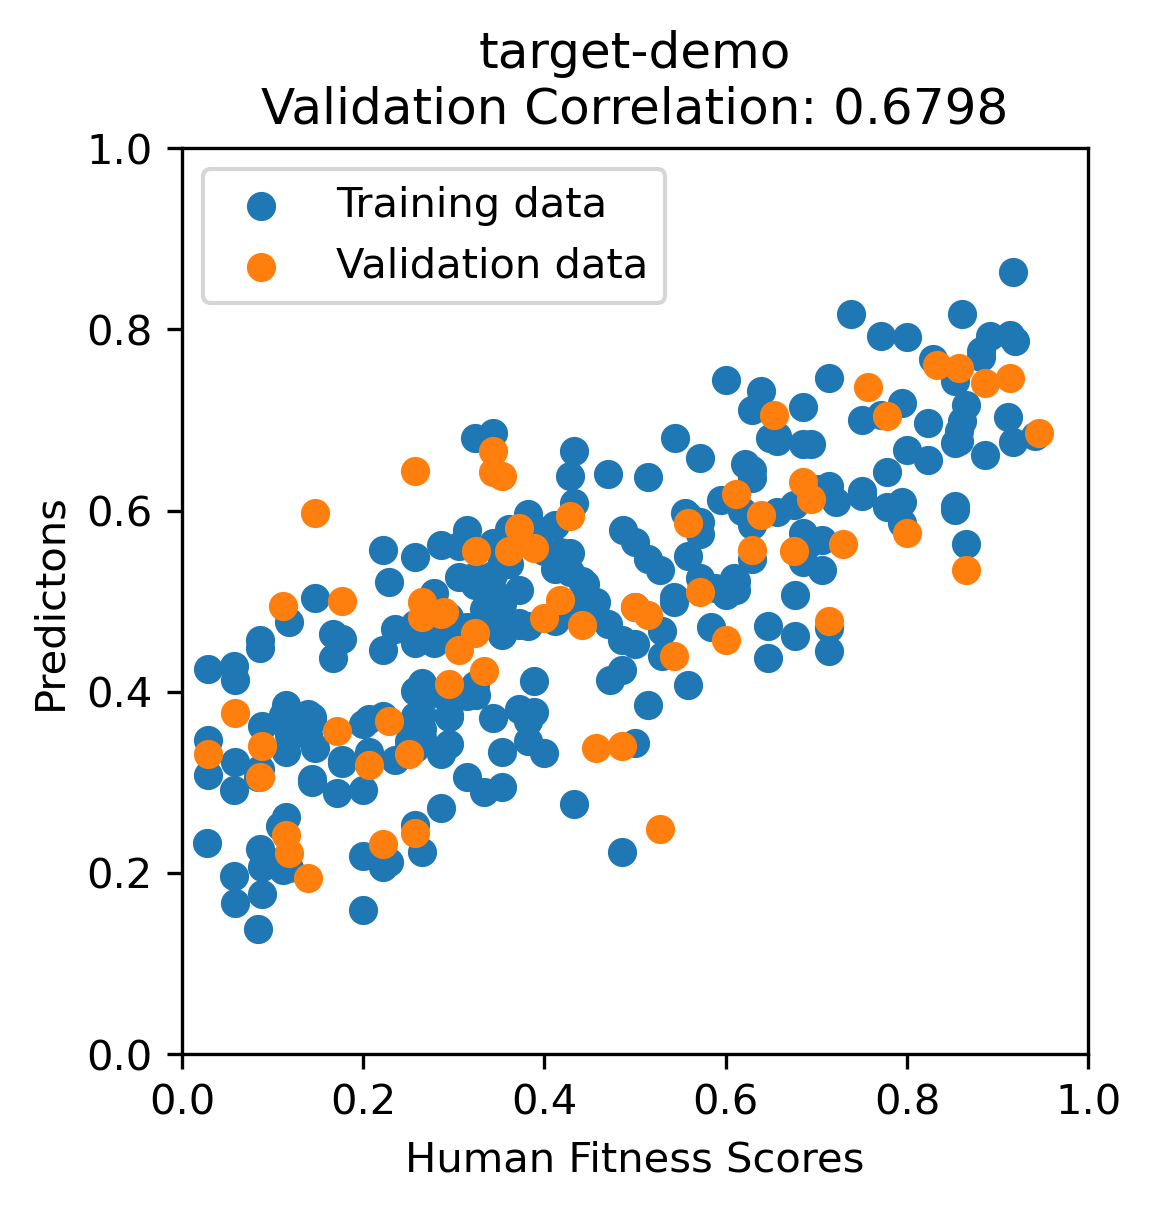

In [17]:
if buildEnv: 

    plt.figure(figsize=(4,4), dpi=300)
    plt.scatter( Y[:,0], pTrainScores, label='Training data' ) 
    plt.scatter( Yval[:,0], pTestScores, label='Validation data' )
    
    plt.xlabel('Human Fitness Scores')
    plt.ylabel('Predictons')
    plt.title("%s\nValidation Correlation: %.4f"% (args.runName, testCorr))
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()

    plt.gca().set_aspect('equal')


# Continue Training?

In [61]:
with strategy.scope():
    
    if buildEnv: 
    
        scale = 0.25
        print( 'LR Before: %f' % args.learning_rate )
        args.learning_rate *= scale
        print( "LR After: % ", args.learning_rate )
        keras.backend.set_value( 
            model.optimizer.learning_rate, 
            float( args.learning_rate ) 
        )

        history = model.fit(
           dg_trainer,
            validation_data = ( Xval, Yval ),
            epochs     = args.num_epochs,
            verbose    = args.verbose,
        )

        # Save loss
        allLoss = np.append( allLoss, history.history['loss'] )
        valLoss = np.append( valLoss, history.history['val_loss'] ) 

        if args.save_model: 
            model.save( 'models/%s-%s-%s.h5' % (args.runName, str(timeid), str(i)), save_format='h5' )

        with open( 'results/%s.txt' % args.runName, 'a' ) as f: 

            print( 'Progress: %d - %d' % ( i, timeid ), file=f )
            print( "Validation accuracy:",*["%.8f"%(x) for x in history.history['loss']], file=f)    
            print( "Test accuracy:",*["%.8f"%(x) for x in history.history['val_loss']],file=f)


LR Before: 0.000025
LR After: %  6.25e-06
Epoch 1/20
16/16 [==============================] - 12s 454ms/step - loss: 0.0803 - val_loss: 0.0746
Epoch 2/20
16/16 [==============================] - 6s 403ms/step - loss: 0.0718 - val_loss: 0.0693
Epoch 3/20
16/16 [==============================] - 7s 408ms/step - loss: 0.0664 - val_loss: 0.0692
Epoch 4/20
16/16 [==============================] - 6s 402ms/step - loss: 0.0675 - val_loss: 0.0679
Epoch 5/20
16/16 [==============================] - 7s 427ms/step - loss: 0.0642 - val_loss: 0.0663
Epoch 6/20
16/16 [==============================] - 6s 401ms/step - loss: 0.0622 - val_loss: 0.0661
Epoch 7/20
16/16 [==============================] - 6s 401ms/step - loss: 0.0610 - val_loss: 0.0664
Epoch 8/20
16/16 [==============================] - 6s 401ms/step - loss: 0.0589 - val_loss: 0.0644
Epoch 9/20
16/16 [==============================] - 7s 403ms/step - loss: 0.0581 - val_loss: 0.0623
Epoch 10/20
16/16 [==============================] - 6s 4

# Save Model?

In [60]:
   
if buildEnv: 
    model.save( 'models/blah-blah.h5' , save_format='h5' )

    with open( 'results/%s.txt' % args.runName , 'w' ) as f: 

        print( 'Progress: %d - %d' % ( i, timeid ), file=f )
        print( "Validation accuracy:",*["%.8f"%(x) for x in allLoss], file=f)    
        print( "Test accuracy:",*["%.8f"%(x) for x in valLoss],file=f)

        
print("Model and Results Saved")

Model and Results Saved


## Keras Tuner?

In [ ]:
def build( hp ):
    
    cmdStr = ''
    cmdStr += ' -runName demo-tuner'
    cmdStr += ' -start 1'
    cmdStr += ' -stop 20'
    cmdStr += ' -num_epochs 20'
    
    cmdStr += ' -learning_rate %f' % hp.Float("lr", default=0.0001, min_value=1e-6, max_value=.01, sampling="log")
    cmdStr += ' -pool %s'          % hp.Choice("pool", [ 'None', 'avg', 'max' ], default=None,  )
    cmdStr += ' -f_depth %d'       % hp.Int( 'f_depth', default=3, min_value=1, max_value=8, step=1 )
    cmdStr += ' -f_width %d'       % hp.Int( 'f_width', default=32, min_value=8, max_value=64, step=8 )
    cmdStr += ' -f_activation %s'  % hp.Choice( 'f_activation', default='tanh', values=[ 'tanh', 'relu' ] )
    cmdStr += ' -output_activation %s' % hp.Choice( 'output_activation', default='linear', \
                                                   values=[ 'linear', 'sigmoid', 'softmax' ] )
    cmdStr += ' -model %s'         % hp.Choice( 'model', default='efficientNetB0', \
                                       values=[ 'efficientNetB0', 'efficientNetB1'] )

    
    print("Parsing Args")
    args = parser.parse_args(cmdStr.split())

    model = buildModel( args, X, Y )
    print('Model: ', model )
    
    return model
    
if buildEnv:
    import keras_tuner as kt

    with strategy.scope():

        hp = kt.HyperParameters()

        # Build Data Generator
        data_generator = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=180,
            zoom_range=0.1,
            horizontal_flip=True,
        )

        dg_trainer = data_generator.flow( 
            X, Y, 
            batch_size = args.batch_size
        )

        print("Something: ")
        tuner = kt.Hyperband(
             build,
             objective=kt.Objective("val_loss", direction="min"),
             max_epochs=10,
             factor=3,
             hyperband_iterations=3,
             directory='tuner',)

        print("Searching: ", )
        tuner.search( dg_trainer, epochs=10, validation_data=(Xval, Yval))


Something: 
INFO:tensorflow:Reloading Oracle from existing project tuner/untitled_project/oracle.json
Parsing Args
Model:  <keras.engine.functional.Functional object at 0x7f41c113b940>
INFO:tensorflow:Reloading Tuner from tuner/untitled_project/tuner0.json
Searching: 

Search: Running Trial #109

Value             |Best Value So Far |Hyperparameter
1.9893e-06        |0.0027144         |lr
None              |max               |pool
1                 |8                 |f_depth
40                |48                |f_width
relu              |relu              |f_activation
sigmoid           |sigmoid           |output_activation
efficientNetB0    |efficientNetB1    |model
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
6                 |6                 |tuner/bracket
0                 |0                 |tuner/round

Parsing Args
Model:  <keras.engine.functional.Functional object at 0x7f41c0192fb0>
Epoch 1/2
 1/16 [>.........